In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, AvgPool1D, Dense, Softmax
from tensorflow.keras.datasets import imdb

In [ ]:
max_features = 18000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
17473536/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


In [ ]:
#Preparing Train and Test Subet set
from sklearn.model_selection import train_test_split

x_train_sub, _,y_train_sub,_ = train_test_split(x_train, y_train, stratify=y_train, train_size=.08, shuffle = True,)
x_test_sub, _, y_test_sub,_ = train_test_split(x_test, y_test, stratify=y_train, train_size=.004, shuffle = True,)

print('Training set size:',x_train_sub.shape)
print('Test set size',x_test_sub.shape)

Training set size: (2000, 80)
Test set size (100, 80)


In [ ]:
#Word Dictionary 
word_dictionary = imdb.get_word_index()

1654784/1641221 [==============================] - 0s 0us/step


In [ ]:
index_to_word_dictionary = dict(zip(word_dictionary.values(),word_dictionary.keys()))

In [ ]:
def index_to_word(index):

  if (index > 0) and (index < len(word_dictionary)):

    return index_to_word_dictionary.get(index)

  return 'not in dictionary'

def show_sentence(x):
  for j in x:
    print(index_to_word(j),' ', end='')
  print()

In [ ]:
#Builiding Model 
e = Embedding(max_features, 80, input_length=80,mask_zero=True)
l = LSTM(80, dropout=0.2, recurrent_dropout=0.2)
d = Dense(1, activation='sigmoid') 

model = Sequential([e,l,d])
#model.add(Softmax())

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 80)            1440000   
                                                                 
 lstm (LSTM)                 (None, 80)                51520     
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 1,491,601
Trainable params: 1,491,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print('Training...')

model.fit(x_train_sub, y_train_sub,
          batch_size=batch_size,
          epochs=3,
          validation_data=(x_test_sub, y_test_sub),
          callbacks = [])

Training...
Epoch 1/3
63/63 [==============================] - 39s 540ms/step - loss: 0.6810 - accuracy: 0.5460 - val_loss: 0.6669 - val_accuracy: 0.5800
Epoch 2/3
63/63 [==============================] - 34s 536ms/step - loss: 0.4288 - accuracy: 0.8230 - val_loss: 0.5180 - val_accuracy: 0.7800
Epoch 3/3
63/63 [==============================] - 34s 537ms/step - loss: 0.1606 - accuracy: 0.9500 - val_loss: 0.6453 - val_accuracy: 0.7200


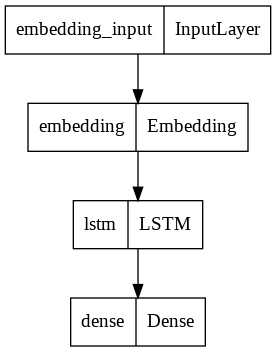

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [ ]:
score, acc = model.evaluate(x_test_sub, y_test_sub,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

4/4 [==============================] - 0s 44ms/step - loss: 0.6453 - accuracy: 0.7200
Test score: 0.6453227996826172
Test accuracy: 0.7200000286102295


In [ ]:
##Create Jacobean function

def jacobian_for(x):
  """
  Calculate jacobian of logits wrt input.
  """
  x = tf.convert_to_tensor(x,dtype=tf.float32)
  x = tf.expand_dims(x,0)

  with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape:
  
  
    tape.watch(e.variables)

    y = model(x)

  return tf.squeeze(tape.jacobian(y, e.variables, parallel_iterations=100, experimental_use_pfor=False))

In [ ]:
def convert_to_label(y):
  if y[0]<=.5:
    y = 0
  else:
    y = 1
  return y


def imdb_attack(f, x, D=np.array(list(word_dictionary.values()),dtype='int64'), max_iter=100):

  """performs attack proposed in Papernot et
al, Crafting Adversarial Input Sequences for Recurrent
Neural Networks."""

  y = f.predict(x)

  y = convert_to_label(y)

  x_ad = x.copy()

  ad_prediction = convert_to_label(f.predict(x_ad))

  jacobian = jacobian_for(np.squeeze(x))

  iteration = 0

  while ad_prediction == y:

    iteration += 1

    if iteration > max_iter:
      break

    #print('\niteration:',iteration)

    i = np.random.randint(0,80,1)[0]

    #print('i:',i)

    #==================TODO==============================
    # 1. Figure out function for w as described in paper
    #
    #====================================================
    j_x = jacobian[i]

    z = tf.argmin(np.sign(D - x_ad[0][i])) #+ 1 #b/c dictionary starts on index 1

    w = np.abs(z - np.sign(j_x[i]))


    #================================================
    #================================================
   
    #=======DELETE WHEN FUNCTION IS FULLY IMPLEMENTED
    if w==None: break 
    #=======DELETE WHEN FUNCTION IS FULLY IMPLEMENTED
    #print('old word:',x_ad[0][i],index_to_word(x_ad[0][i]))

    if not w < max_features:
      continue

    #print('new word:',w,index_to_word(w))

    
    x_ad[0][i]=w

    ad_prediction = convert_to_label(f.predict(x_ad))

  #return adversarial example

  if ad_prediction != y:
    print(' NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN',iteration,'ITERATIONS')

  return x_ad

In [ ]:
np.average([7,1,19,77,47,2,19,7,66,71,65,27,88,73,15,15,23,10,38,29,28,4,58,35,1,27,25,12,36,66,12,16,30,88,17,41,72,2,77,15,1,62,12,22,59,40,64,57,29,61,11,11,89,53])

35.77777777777778

In [ ]:
#creting adversarial examples
adversarial_example = np.array([imdb_attack(model,np.expand_dims(i,0)) for i in x_test_sub]).squeeze()

 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 3 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 12 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 38 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 10 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 5 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 19 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 71 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 50 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 35 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 51 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 45 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 3 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 40 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 76 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 2 ITERATIONS
 NEW ADVERSARIAL EXAMPLE SUCCESSFULLY CREATED IN 6 ITERATIO

In [ ]:
for i in range(len(adversarial_example)):
  print('Sentence ',i,'Original')
  
  show_sentence(x_test_sub[i])

  print('\nSentence ',i,'Adversarial')

  show_sentence(adversarial_example[i])

  print('===========================================================================================================================================================\n')

Sentence  0 Original
but  they're  are  here  to  movie  anything  movie  never  ghosts  book  was  out  nothing  kids  in  can  scenes  watch  scenes  watch  scenes  br  behind  and  camera  of  able  br  of  mistake  america  looking  that  it's  his  more  it  is  scenes  know  attention  br  of  behind  he  some  marjorie  overtones  i  i  an  this  an  was  had  asked  as  on  to  if  is  dramatic  movie  was  family  point  did  premise  many  out  his  zombie  way  to  combined  huge  just  as  by  

Sentence  0 Adversarial
but  they're  are  here  to  movie  anything  movie  never  is  book  was  out  nothing  i'm  in  can  scenes  watch  scenes  watch  scenes  br  behind  and  camera  of  able  br  of  mistake  america  looking  that  it's  his  more  it  is  scenes  know  attention  br  of  behind  he  some  marjorie  overtones  i  i  an  this  an  was  had  asked  as  on  to  if  is  dramatic  movie  was  real  point  did  premise  many  out  his  zombie  way  to  combined  

In [ ]:
#testing model on adversarial examples
print(model.evaluate(x_test_sub,y_test_sub,batch_size=batch_size))
print(model.evaluate(adversarial_example, y_test_sub, batch_size=batch_size))

4/4 [==============================] - 0s 42ms/step - loss: 0.6453 - accuracy: 0.7200
[0.6453227996826172, 0.7200000286102295]
4/4 [==============================] - 0s 43ms/step - loss: 0.6881 - accuracy: 0.5200
[0.6880773901939392, 0.5199999809265137]
